## Principal Components Analysis (PCA)

PCA is another term for SVD when it is used for dimension reduction, to which LSA is in part constructed from.
<br>
The PCA model in `sklearn` contains some tweaks to the **SVD** math that'll improve the accuracy of a NLP pipeline.
<br>
* operations - `sklearn.PCA` automatically ***centres*** the data by subtracting off the mean word frequencies. Additionally, a more subtle trick is that PCA uses a function known as `flip_sign` to compute the sign of the singular vectors
* optional - The `sklearn` implementation of PCA implements an optional 'whitening' step. This is also similar to the trick of ignoring the singular values when transforming word-document vectors into topic-document vectors. Also, instead of just setting all the singular values is $S$ to one, whitening divides the data by the variances similar to how `sklearn.StandardScalar` transform does. This helps spread out the data and make any optimisation algorithm less likely to get get confused parts of the data that can arise when features in our dataset are correlated with each other 

PCA is useful for a wide range of applications, which is helpful to know as it can perform data science techniques beyond NLP.
<br>
For most applied problems, we'll want to use the `sklearn.PCA` model for a LSA model.

As an initial example, We're going to begin with a set of real-world 3D vectors rather than +10k dimensional document-word vectors - given it's easier to visualise things in 3D than in 10000-D.

### PCA on 3D vectors 

SVD preserves the structure and information content of one's vectors by ***maximising*** the variance along the dimensions of our lower-dimensional 'shadow' of the high-dimensional space.
<br>
This is optimal for ML so that each low-dimensional vector captures the 'essence' of whatever it represents.
<br>
* heuristic - SVD ***maximises*** the variance along each axis (dimensions), to which variance turns out to be decent indicator of 'information' or the 'essence' one is searching for 

In [2]:
import pandas as pd 
import seaborn as sns 
pd.set_option('display.max_columns', 6)
from sklearn.decomposition import PCA # this is still technically SVD
from nlpia.data.loaders import get_data
import matplotlib.pyplot as plt 
%matplotlib inline 

In [3]:
df = get_data('pointcloud').sample(1000)
pca = PCA(n_components=2)

In [4]:
df2d = pd.DataFrame(pca.fit_transform(df), columns=list('xy'))
df2d.head()

,x,y
0,0.076827,-0.026613
1,-0.049877,-0.002330
2,-0.019032,0.067518
3,0.031422,-0.018373
4,-0.093715,0.029935


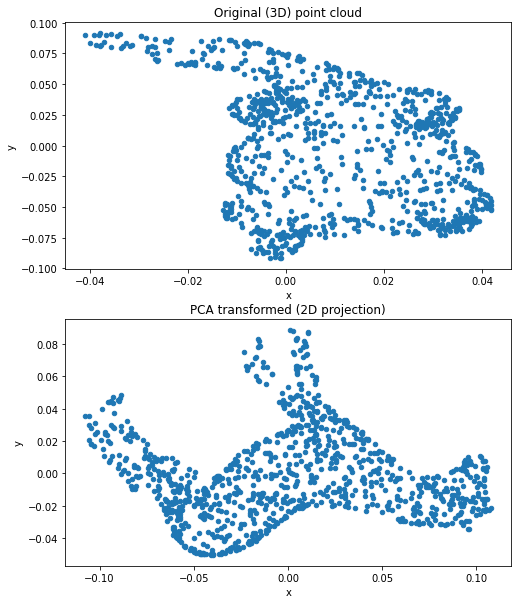

In [5]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=[8,10])
#plt.rcParams['figure.figsize'] = 8,12
df.plot(kind='scatter', x='x', y='y', ax=ax1, title='Original (3D) point cloud')
df2d.plot(kind='scatter', x='x', y='y', ax=ax2, title='PCA transformed (2D projection)')
plt.show();

The orientation of the 2D projection is computed so that the variance is always aligned with the x-axis (first axis).
<br>
The second largest variance is always aligned with the y-axis, the second dimension of our 'shadow'/'projection'.
<br>
Linear SVD and PCA do a good job of preserving the 'information' in the point cloud vector data 

### PCA (SVD) for NLP

Now, it's relevant to see how SVD will operate on natural language documents. 
This experiment will involve finding the principal components using SVD on the 5k SMS messages labelled as spam or not (ham).
<br>
Topic groupings should be small given a dataset with this sample size - limit to 16 topics.
<br> 
Within `sklearn`, there are two model methods to perform SVD on textual data, comparing the *differences*:
* `TruncatedSVD` - Created to work with ***sparse matrices***, where matrices have the same value (mostly zeros/NaNs) across many cells. This is almost always the case for BOW/TF-IDF word matrix transformations, given most documents don't contain many words of the words in our vocabulary. Hence, most of the word counts are zero
* `PCA` - Such model may provide a faster solution than the former (truncated SVD) by using dense matrices with all those zeros filled in. Although this comes at the cost of excessive RAM given it attempts to remember every single one of the zeros that are duplicated all over the place. Hence, when using `TfidfVectorizer`, it'll output sparse matrices, so we need to convert to dense matrices before we compare the results to PCA


In [6]:
import pandas as pd 
from nlpia.data.loaders import get_data
pd.options.display.width = 120 

In [7]:
sms = get_data('sms-spam')
index = ['sms{}{}'.format(i, '!'*j) for (i,j) in zip(range(len(sms)), sms.spam)]
sms.index = index 
sms.head(6)

,spam,text
sms0,0,"Go until jurong point, crazy.. Available only ..."
sms1,0,Ok lar... Joking wif u oni...
sms2!,1,Free entry in 2 a wkly comp to win FA Cup fina...
sms3,0,U dun say so early hor... U c already then say...
sms4,0,"Nah I don't think he goes to usf, he lives aro..."
sms5!,1,FreeMsg Hey there darling it's been 3 week's n...


In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize.casual import casual_tokenize

tfidf = TfidfVectorizer(tokenizer=casual_tokenize)
tfidf_docs = tfidf.fit_transform(raw_documents=sms['text']).toarray()

In [9]:
# length of tfidf model vocabulary
print(len(tfidf.vocabulary_))
tfidf_docs = pd.DataFrame(tfidf_docs)
tfidf_docs = tfidf_docs - tfidf_docs.mean()
tfidf_docs.shape

9232


(4837, 9232)

In [10]:
# number of spam messages within the dataset
len(sms[sms['spam'] == 1])

638

From this EDA, we can see that this dataset comprises of:
* Rows - 4837 (messages)
* Columns - 9232 (token n-grams per `casual_tokenize`)
* **spam** labels (1) - 638/4837 which is 13% 

We have a unbalanced training set with about 8:1 ham (normal SMS messages) to spam (unwanted solicitation and advertisements).


We might deal with this ham sampling bias by reducing the 'reward' for any model that classifies ham messages correctly.
* Large vocabulary size - Given the vocabulary size $|V|$ which is hard to deal with
* Token size - The 9232 tokens in the vocabulary is greater than the 4837 messages (samples) we have to go on, where we have a lot more distinct words in our vocabulary/lexicon than we have SMS meesages

Given these considerations along with a small portion of messages ($1/8^{th}$) labelled as spam, we can fall prey to the problem of **overfitting**. Hence only a few distinct portion of words out of this relatively large lexicon will be classified as 'spammy' words in our dataset.

Overfitting typically means that a person who uses such model will partition off only a few words in our vocabulary.
* Limitations - Spam filter will be dependent on those spammy words being somewhere in the spammy messages it filters out. Spammers could dodge the filter if they simply used synonyms for such spammy words. Hence, such messages using synonyms when not present in a trained vocabulary for detecting spam messages will erroneously classify these deceptive as ham
* Solving the problem - The overfitting problem is an inherent phenomena in NLP. It's not easy to find a large natural language dataset that includes all the permutations that people might say something that should be labelled correctly. Hence, we need to utilise countermeasures for overfitting, which can include additional algorithms that we use along side our foundational ones so that a core model can generalize well on just a few (unseen) examples

Dimension reduction tends to be the primary countermeasure for overfitting, by consolidating our dimensions (words) into a smaller number of dimensions (topics) - such NLP pipeline will become more general.
<br>
Such spam filter will work on a wider range of SMS messages if we reduce our dimensions or vocabulary.
* LSA purpose - LSA ensures dimension reduction and can help prevent overfitting, generalizing from a sample dataset by assuming a linear relationship between word counts 
* Instances - For examples if the word 'half' occurs in spam messages containing words like 'off' a lot (as in 'half off'), LSA helps one make such connections between words and detects how strong they are so it'll generalize from the phrase 'half off' in a spam message to phrases like '80% off'


Generalizing a NLP pipeline ensures that it applies to a broader set of real-world SMS messages instead of just a particular subset of messages.

### Using PCA for SMS message semantic analysis

Gathering the dataset of 9232-D TF-IDF vectors into 16-D topic vectors 

In [11]:
from sklearn.decomposition import PCA

In [12]:
pca = PCA(n_components=16)
# saves us one more step performing fit_transform simultaneously on training set s
pca_topic_vectors = pca.fit_transform(tfidf_docs)

In [13]:
columns = [f'topic{i}' for i in range(pca.n_components_)]

In [14]:
pca_topic_vectors_df = pd.DataFrame(pca_topic_vectors, columns=columns, index=index)

In [15]:
pca_topic_vectors_df.round(3).head(6)

,topic0,topic1,topic2,...,topic13,topic14,topic15
sms0,0.201,0.003,0.037,...,-0.030,-0.011,0.025
sms1,0.404,-0.094,-0.078,...,-0.033,0.050,-0.043
sms2!,-0.030,-0.048,0.090,...,-0.033,-0.033,0.051
sms3,0.329,-0.033,-0.035,...,-0.065,0.029,-0.062
sms4,0.002,0.031,0.038,...,0.023,-0.075,-0.032
sms5!,-0.016,0.059,0.014,...,0.078,-0.010,0.030


If one is curious about such topics, we can find out how much of each word the topic contains by inspecting the weights. 
<br>
Glancing at the weights can help us understand how often 'half' occurs with the word 'off' such as 'half off' to then decipher which topic is the discount topic.
<br>
We can find the weights of any `sklearn` fitted PCA transformation by examining its **.components_** attribute.

It can be better to assign words to all the dimensions in a PCA transformation.
* Order - We need such words to be in the right order as `TfidfVectorizer` stores the vocabulary as a dictionary that maps each term to an index (column) number 

In [16]:
# first five word tokens with the their corresponding column position as an example
list(tfidf.vocabulary_.items())[:5]

[('go', 3807), ('until', 8487), ('jurong', 4675), ('point', 6296), (',', 13)]

The cell directly below ensures that we want to sort by columns (index) and terms (i.e. unzip) and then maintain this corresponding relationship by rezip these data collections after sorting.

In [17]:
# Will sort based on ASCII convention
columns_nums, terms = zip(*sorted(zip(tfidf.vocabulary_.values(), tfidf.vocabulary_.keys())))

After performing this operation, we can allocate a clean DataFrame containing the weights, with labels for all the columns and rows in the correct position.

In [18]:
weights = pd.DataFrame(pca.components_, columns=terms, index=[f'topic{i}' for i in range(16)])
pd.options.display.max_columns = 8 
weights.head(4).round(3)

,!,"""",#,#150,...,…,┾,〨ud,鈥
topic0,-0.071,0.008,-0.001,-0.000,...,-0.002,0.001,0.001,0.001
topic1,0.064,0.008,0.000,-0.000,...,0.003,0.001,0.001,0.001
topic2,0.071,0.027,0.000,0.001,...,0.002,-0.001,-0.001,-0.001
topic3,-0.059,-0.032,-0.001,-0.000,...,0.001,0.001,0.001,0.001


As above, some of the columns (terms) are not significant/conducive for insights. 
<br>
Hence, we can experiment and find some of those 'half off' terms and which topics they're part of:

In [19]:
pd.options.display.max_columns = 12
deals = weights['! ;) :) half off free crazy deal only $ 80 %'.split()].round(3) * 100
deals

,!,;),:),half,off,free,crazy,deal,only,$,80,%
topic0,-7.1,0.1,-0.5,-0.0,-0.4,-2.0,-0.0,-0.1,-2.2,0.3,-0.0,-0.0
topic1,6.4,0.0,7.4,0.1,0.4,-2.3,-0.2,-0.1,-3.8,-0.1,-0.0,-0.2
topic2,7.1,0.2,-0.1,0.0,0.3,4.4,0.1,-0.1,0.7,0.0,0.0,0.1
topic3,-5.9,-0.3,-7.1,0.2,0.3,-0.2,0.0,0.1,-2.3,0.1,-0.1,-0.3
topic4,38.1,-0.1,-12.4,-0.1,-0.2,9.9,0.1,-0.2,3.0,0.3,0.1,-0.1
topic5,-26.5,0.1,-1.5,-0.3,-0.7,-1.4,-0.6,-0.2,-1.8,-0.9,0.0,0.0
topic6,-11.0,-0.5,19.9,-0.4,-0.9,-0.6,-0.2,-0.1,-1.4,-0.0,-0.0,-0.1
topic7,16.5,0.1,-17.7,0.8,0.8,-2.7,0.0,0.1,-1.9,-0.3,0.0,-0.1
topic8,34.1,0.1,5.5,-0.4,-0.5,0.1,-0.4,-0.4,3.2,-0.6,-0.0,-0.2
topic9,7.8,-0.3,16.0,1.4,-1.0,6.2,-0.5,-0.4,3.1,-0.5,-0.0,-0.0


In [20]:
deals.T.sum()

topic0    -11.9
topic1      7.6
topic2     12.7
topic3    -15.5
topic4     38.4
topic5    -33.8
topic6      4.7
topic7     -4.4
topic8     40.5
topic9     31.8
topic10   -30.3
topic11    49.5
topic12    20.8
topic13    47.9
topic14    18.9
topic15     3.1
dtype: float64

From this basic EDA we infer that:
* Positive deals (relevant to topic at hand) - Topics 4, 8, 9 etc. contain positive 'deal' topic sentiment which links to the idea of 'deals' in this case
* Negative deals (irrelevant to topic at hand) - Topics 0, 3, 5 etc. contain negative 'deal' topic sentiment which is away from the idea of 'deals' in this case

Hence, this experiment shows that words associated with 'deals' can have a positive impact on some topics and a negative impact on others. There's no single obvious 'deal' topic number.

***Implications***
<br>
<br>
Ultimately, one of the challenges of LSA (especially the above implementation) is being able to make sense of the topics - given we usually have a relatively small corpus to work with.
<br>
The topics tend to combine words in ways that humans don't find very much meaningful. Several words from different topics will be merged together into a single topic (principle component) so that the model captures as much variance in the usage of the word feature vectors as much as possible.

### Using truncated SVD for SMS message semantic analysis

We also try the `TruncatedSVD` model in the `sklearn` API.
<br>
This is also considered a more direct approach to bypass the `sklearn PCA` model so we can see what's going on inside the `PCA` wrapper.
* Matrices input - Such model can handle ***sparse matrices***, so when working with large datasets, we'll likely want to use `TruncatedSVD` instead of `PCA` anyway
* `SVD` process - This will split the TF-IDF matrix into three matrices
* `Truncated` process - This will discard the dimensions that contain the least information about our TF-IDF matrix 
* Discarded elements - These discarded dimensions represent the 'topics' (linear combination of words) that vary the least within a specific document set. Discarded topics would likely be meaningless to the overall semantics of such corpus. They would contain many stop words and other words that are uniformly distributed across all the documents

Using `TruncatedSVD` to retain only the 16 most interesting topics i.e. the topics the account for the most variance in our TF-IDF vectors:

In [21]:
from sklearn.decomposition import TruncatedSVD

In [22]:
# n_iter is 100 to ensure we get a replica output to the PCA model
svd = TruncatedSVD(n_components=16, n_iter=100)

# pass input in the format of numpy arrays while decomposing TF-IDF vectors and transforming them into topic vectors simultaneously
svd_topic_vectors = svd.fit_transform(tfidf_docs.values)

In [23]:
svd_topic_vectors = pd.DataFrame(svd_topic_vectors, columns=columns, index=index)
svd_topic_vectors.round(3).head(6)

,topic0,topic1,topic2,topic3,topic4,topic5,...,topic10,topic11,topic12,topic13,topic14,topic15
sms0,0.201,0.003,0.037,0.011,-0.019,-0.053,...,0.007,-0.007,0.002,-0.036,-0.014,0.037
sms1,0.404,-0.094,-0.078,0.051,0.100,0.047,...,-0.004,0.036,0.043,-0.021,0.051,-0.042
sms2!,-0.030,-0.048,0.090,-0.067,0.091,-0.043,...,0.125,0.023,0.026,-0.020,-0.042,0.052
sms3,0.329,-0.033,-0.035,-0.016,0.052,0.056,...,0.022,0.023,0.073,-0.046,0.022,-0.070
sms4,0.002,0.031,0.038,0.034,-0.075,-0.093,...,0.028,-0.009,0.027,0.034,-0.083,-0.021
sms5!,-0.016,0.059,0.014,-0.006,0.122,-0.040,...,0.041,0.055,-0.037,0.075,-0.001,0.020


the topic vectors from `TruncatedSVD` are identical to what `PCA` churned out - given such results emphasises the following:
<br>
<br>
1) Large number of iterations (n_iter)
<br>
2) All our TF-IDF frequencies for each term (column) were centered on zero (by subtracting the mean for each term) 

### How well does LSA work for spam classification?

A method to detect how well a vector space model will work for classification is to see how cosine similarities between vectors correlate with membership in the same class.
<br>
It's intriguing to see if the cosine similarity between corresponding pairs of documents is useful for our particular binary classification.

To evaluate if this process works, we'll compute the dot product between the first six topic vectors for the first six SMS messages.
<br>
We should see larger positive cosine similarity (dot products) between any spam message (i.e. 'sms2!')

Normalizing each topic vector by its length (L2-norm) allows us to compute the cosine distances with a dot product - remember the cosine similarity formula is composed of:
<br>
<br>
$cos (\Theta)$ = $\frac{A \times B}{|A| \times |B|}$

In [25]:
import numpy as np 

svd_topic_vectors = (svd_topic_vectors.T/np.linalg.norm(svd_topic_vectors, axis=1)).T
svd_topic_vectors.iloc[:10].dot(svd_topic_vectors.iloc[:10].T).round(1)

,sms0,sms1,sms2!,sms3,sms4,sms5!,sms6,sms7,sms8!,sms9!
sms0,1.0,0.6,-0.1,0.6,-0.0,-0.3,-0.3,-0.1,-0.3,-0.3
sms1,0.6,1.0,-0.2,0.8,-0.2,0.0,-0.2,-0.2,-0.1,-0.1
sms2!,-0.1,-0.2,1.0,-0.2,0.1,0.4,0.0,0.3,0.5,0.4
sms3,0.6,0.8,-0.2,1.0,-0.2,-0.3,-0.1,-0.3,-0.2,-0.1
sms4,-0.0,-0.2,0.1,-0.2,1.0,0.2,0.0,0.1,-0.4,-0.2
sms5!,-0.3,0.0,0.4,-0.3,0.2,1.0,-0.1,0.1,0.3,0.4
sms6,-0.3,-0.2,0.0,-0.1,0.0,-0.1,1.0,0.1,-0.2,-0.2
sms7,-0.1,-0.2,0.3,-0.3,0.1,0.1,0.1,1.0,0.1,0.4
sms8!,-0.3,-0.1,0.5,-0.2,-0.4,0.3,-0.2,0.1,1.0,0.3
sms9!,-0.3,-0.1,0.4,-0.1,-0.2,0.4,-0.2,0.4,0.3,1.0


Reading down the 'sms0' column (or across the 'sms0' row), the cosine similarity between 'sms0' and the spam messages ('sms2!', 'sms5!', 'sms8!', 'sms9!') is significantly negative.
* Heuristic (nonspam) - The topic vector for 'sms0' is very different from the topic vector for spam messages. A nonspam message doesn't talk about the same thing as spam messages 
* Heuristic (spam) - As with the topic vector for 'sms2!' column, it should show a positive correlation with other spam messages. Spam messages share similar semantics given they talk about similar topics
* Semantic search operations - In terms of semantic search mechanics, we can use the cosine similarity between a query vector and all the topic vectors for our database of documents to find the most semantically similar messages in a corresponding database. The closest document (smallest distance) to the vector for that query would correspond to the document with the closest meaning. Spaminess in such cases can be one of the 'meanings' mixed into our SMS message topics

***Implications***
<br>
<br>
Unfortunately, such similarity between topic vectors within each class (spam and nonspam) is not maintained for all the messages. Setting a 'line' (decision boundary such as the case for perceptrons) between spam and nonspam messages would be difficult for this set of topic vectors.
<br>
We'd have a hard time of setting a threshold on the similarity to an individual spam message that would ensure that we would always be able to classify spam and nonspam correctly - even though we could still get the gist of classification from the heuristics (spam or nonspam).
<br>
These are the ingredients to build a spam filter using such topic vectors.
<br>
A ML algorithm can look at all the topics individually for all the spam and nonspam labels and could draw a hyperplane/boundary between the spam and nonspam messages.

While using truncated SVD, it's advised to discard the eigenvalues before computing the topic vectors. We configured the `sklearn` implementation of `TruncatedSVD` into ignoring the scale information within the eigenvalues (the `Sigma (S)` matrix in our mental model of SVD) by:
* Normalizing the TF-IDF vectors by their length (L$^{2}$-norm)
* Centring the TF-IDF term frequencies by subtracting the mean frequency for each term (word)

The normalization process eliminates any such scaling/bias in the eigenvalues and focuses such SVD on the rotation part of the transformation of our TF-IDF vectors.
<br>
By ignoring the eigenvalues (vector scale or length), we can 'square up' the hypercube that bounds the topic vector space, which allows us to treat all topics as equally important in a constructed model. 
<br>
To use this trick within a SVD transformation, we can normalize all the TF-IDF vectors by the (L$^{2}$-norm) before computing the SVD or truncated SVD. 
<br> 
The `sklearn` implementation of `PCA` does this for us by 'centring' and 'whitening' our data.

Without such normalization methods, infrequent topics will be given slightly more weight than they would otherwise. As 'spaminess' is a rare topic (occuring only 13% of the time in the SMS dataset), the topics that measure it would be given more weight by this normalization or eigenvalue discarding.

The breakthroughs regarding SVD for semantic analysis and dimension reduction has motivated further research for wider applications.
<br>
Such enhancements are intended mostly for non-NLP problems.
<br>
They're from time to time used for behaviour-based recommendation engines alongside NLP content-based recommendation engines - having also been used on natural language part-of-speech statistics.
<br>
Any matrix factorisation or dimension reduction approach can be used with natural language term frequencies - there may have a purpose in a given semantic analysis pipeline:
* Quadratic discriminant analysis (QDA) 
* Random projection 
* Nonnegative matrix factorisation (NMF)

QDA is an alternative to linear discriminant analysis (LDA). QDA creates quadratic polynomial transformations, rather than linear transformations. Such transformations define a vector space that can be used to discriminate between classes.
<br>
The boundary between classes in a QDA vector space is quadratic/curved like a sphere.

Random projection is a matrix decomposition and transformation approach similar to SVD, although the algorithm is stochastic, retrieving a different answer over each run through.
<br>
However, this stochastic nature makes easier to run in parallel and in some cases (parts of random runs), one can retrieve transformations that are better than what comes out of SVD and LSA.
<br>
Ultimately, random projection is rarely used among NLP problems, neither is there any wide utilised implementations of it in NLP packages such as SpaCy or NLTK.

Overall, for most cases, we're better off sticking with LSA, which uses the true and tried SVD algorithm under the hood.
* SVD has traditionally been used to compute the 'pseudo-inverse' on nonsquare matrices and many applications exist for matrix inversion